### Goals:



#### G1: Given probability distributions $p$ and $q$, find the divergence (measure of similarity) between them

Let us first look at G1. Look at the illustration below. We have a normal distribution $p$ and two other normal distributions $q_1$ and $q_2$. Which of $q_1$ and $q_2$, would we consider closer to $p$? $q_2$, right? 

![](dkl.png)

To understand the notion of similarity, we use a metric called the KL-divergence given as $D_{KL}(a || b)$ where $a$ and $b$ are the two distributions. 

For G1, we can say $q_2$ is closer to $p$ compared to $q_1$ as:

$D_{KL}(q_2 || p) \lt D_{KL}(q_1 || p)$

For the above example, we have the values as $D_{KL}(q_2|| p) = 0.07$ and $D_{KL}(q_1|| p)= 0.35$

#### G2: assuming $p$ to be fixed, can we find optimum parameters of $q$ to make it as close as possible to $p$

The following GIF shows the process of finding the optimum set of parameters for a normal distribution $q$ so that it becomes as close as possible to $p$. This is equivalent of minimizing $D_{KL}(q || p)$


![](kl_qp.gif)

The following GIF shows the above but for a two-dimensional distribution.


![](kl_qp_2.gif)

#### G3: finding the "distance" between two distributions of different families


The below image shows the KL-divergence between distribution 1 (mixture of Gaussians) and distribution 2 (Gaussian)

![](dkl-different.png)


#### G4: optimizing the "distance" between two distributions of different families

The below GIF shows the optimization of the KL-divergence between distribution 1 (mixture of Gaussians) and distribution 2 (Gaussian)

![](kl_qp_mg.gif)


#### G5: Approximating the KL-divergence

#### G6: Implementing variational inference for linear regression




### Basic Imports

In [1]:
%pip install -U git+https://github.com/sustainability-lab/ASTRA

  Cloning https://github.com/sustainability-lab/ASTRA to /tmp/pip-req-build-zipq_98g
  Running command git clone --filter=blob:none -q https://github.com/sustainability-lab/ASTRA /tmp/pip-req-build-zipq_98g
  Resolved https://github.com/sustainability-lab/ASTRA to commit 99a7e7f36f94e2bd51bd9b37e91e1349fa799df3
  Installing build dependencies ... ^C
canceled
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns

from ipywidgets import interact

from astra.torch.utils import train_fn
from astra.torch.models import AstraModel

dist =torch.distributions

# Default figure size for matplotlib
plt.rcParams['figure.figsize'] = (6, 4)

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Creating distributions

#### Creating $p\sim\mathcal{N}(1.00, 4.00)$

In [3]:
p = dist.Normal(1, 4)

Text(0, 0.5, 'PDF')

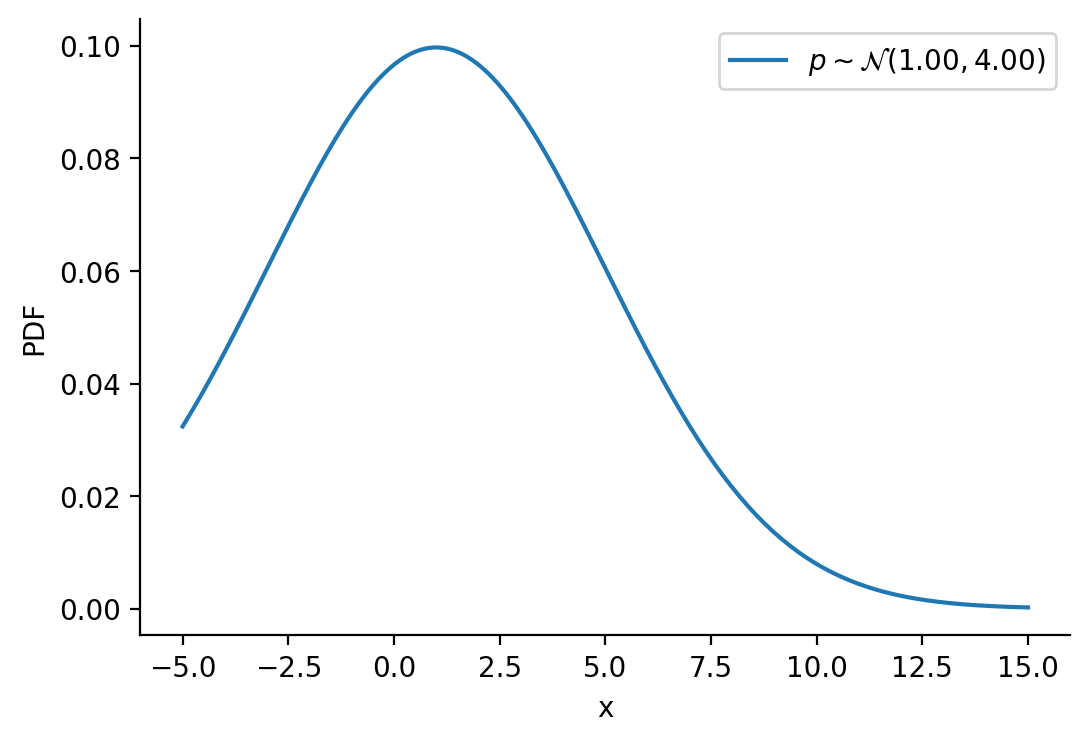

In [4]:
z_values = torch.linspace(-5, 15, 200)
prob_values_p = torch.exp(p.log_prob(z_values))
plt.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$")
sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")

#### Creating $q\sim\mathcal{N}(loc, scale)$

In [ ]:
def create_q(loc, scale):
    return dist.Normal(loc, scale)

#### Generating a few qs for different location and scale value

In [ ]:
q = {}
q[(0, 1)] = create_q(0.0, 1.0)

for loc in [0, 1]:
    for scale in [1, 2]:
        q[(loc, scale)] = create_q(float(loc), float(scale))

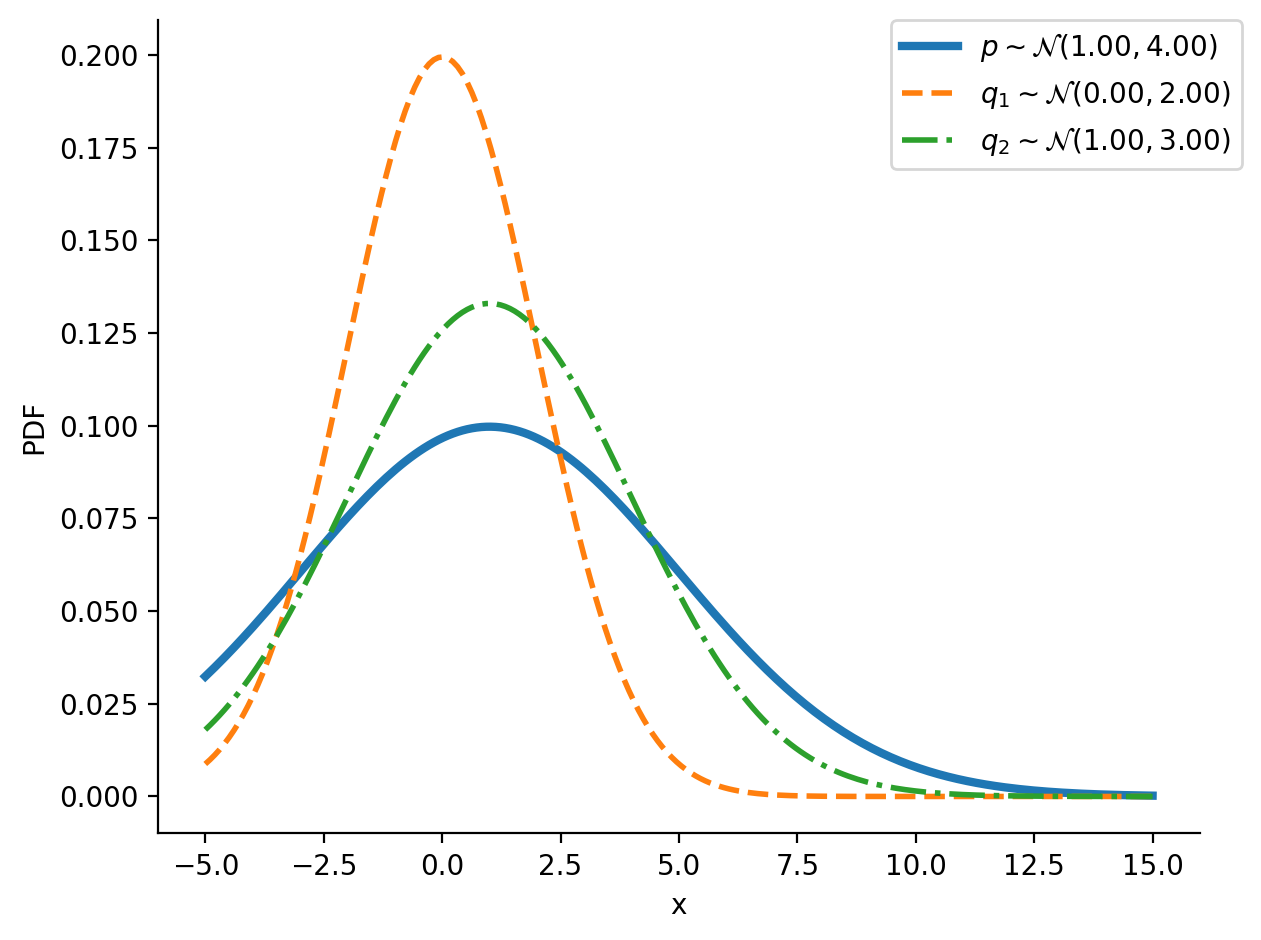

In [ ]:
plt.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$", lw=3)
plt.plot(
    z_values,
    torch.exp(create_q(0.0, 2.0).log_prob(z_values)),
    label=r"$q_1\sim\mathcal{N}(0.00, 2.00)$",
    lw=2,
    linestyle="--",
)
plt.plot(
    z_values,
    torch.exp(create_q(1.0, 3.0).log_prob(z_values)),
    label=r"$q_2\sim\mathcal{N}(1.00, 3.00)$",
    lw=2,
    linestyle="-.",
)

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()
plt.tight_layout()
plt.savefig(
    "dkl.png",
    dpi=150,
)

In [ ]:
#### Computing KL-divergence

q_0_2_dkl = dist.kl_divergence(create_q(0.0, 2.0), p)
q_1_3_dkl = dist.kl_divergence(create_q(1.0, 3.0), p)

print(f"D_KL (q(0, 2)||p) = {q_0_2_dkl:0.2f}")
print(f"D_KL (q(1, 3)||p) = {q_1_3_dkl:0.2f}")

D_KL (q(0, 2)||p) = 0.35
D_KL (q(1, 3)||p) = 0.07


As mentioned earlier, clearly, $q_2\sim\mathcal{N}(1.00, 3.00)$ seems closer to $p$

### Optimizing the KL-divergence between q and p

We could create a grid of (loc, scale) pairs and find the best, as shown below.

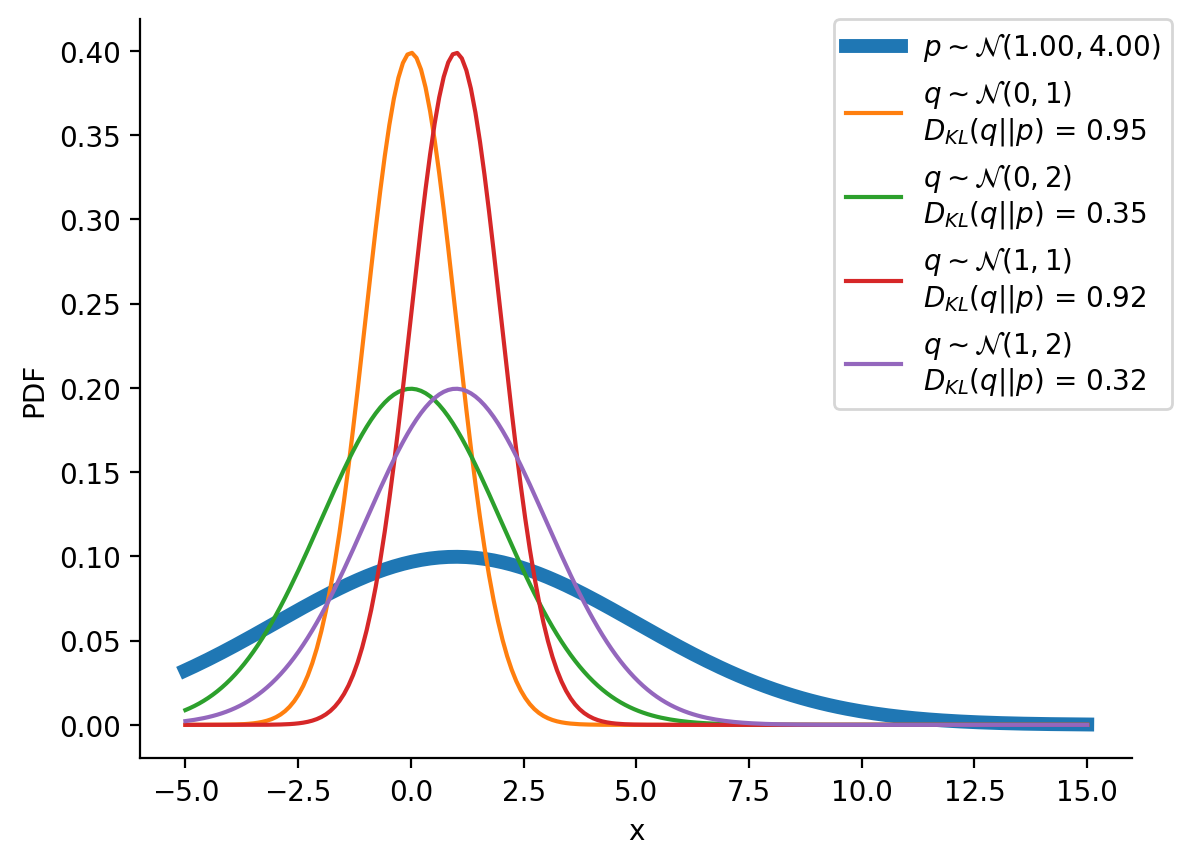

In [ ]:
plt.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$", lw=5)


for loc in [0, 1]:
    for scale in [1, 2]:
        q_d = q[(loc, scale)]
        kl_d = dist.kl_divergence(q[(loc, scale)], p)
        plt.plot(
            z_values,
            torch.exp(q_d.log_prob(z_values)),
            label=rf"$q\sim\mathcal{{N}}({loc}, {scale})$"
            + "\n"
            + rf"$D_{{KL}}(q||p)$ = {kl_d:0.2f}",
        )
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()

Or, we could use continuous optimization to find the best loc and scale parameters for q.

In [ ]:
class TrainableNormal(torch.nn.Module):
    def __init__(self, loc, scale):
        super().__init__()
        self.loc = nn.Parameter(torch.tensor(loc))
        raw_scale = torch.log(torch.expm1(torch.tensor(scale)))
        self.raw_scale = nn.Parameter(raw_scale)
            
    def forward(self, X=None):
        scale = torch.functional.F.softplus(self.raw_scale)
        return dist.Normal(loc=self.loc, scale=scale)
    
    def __repr__(self):
        return f"TrainableNormal(loc={self.loc.item():0.2f}, scale={torch.functional.F.softplus(self.raw_scale).item():0.2f})"
    
def loss_fn(to_learn, p):
    return dist.kl_divergence(to_learn, p)
    
loc = 4.0
scale = 0.5
model = TrainableNormal(loc=loc, scale=scale)
loc_array = [torch.tensor(loc)]
scale_array = [torch.tensor(scale)]
loss_array = [loss_fn(model(), p).item()]
opt = torch.optim.Adam(model.parameters(), lr=0.05)
epochs = 100
for i in range(4):
    iter_losses, epoch_losses, state_dict_list = train_fn(model, inputs=None, outputs=p, loss_fn=loss_fn, optimizer=opt, epochs=epochs, verbose=False, get_state_dict=True)
    loss_array.extend(epoch_losses)
    loc_array.extend([state_dict["loc"] for state_dict in state_dict_list])
    scale_array.extend([torch.functional.F.softplus(state_dict["raw_scale"]) for state_dict in state_dict_list])

    print(
        f"Iteration: {i*epochs}, Loss: {epoch_losses[-1]:0.2f}, Loc: {loc_array[-1]:0.2f}, Scale: {scale_array[-1]:0.2f}"
    )

Iteration: 0, Loss: 0.05, Loc: 1.06, Scale: 3.15
Iteration: 100, Loss: 0.00, Loc: 1.00, Scale: 3.92
Iteration: 200, Loss: 0.00, Loc: 1.00, Scale: 4.00
Iteration: 300, Loss: 0.00, Loc: 1.00, Scale: 4.00


Text(0.5, 0, 'Iteration')

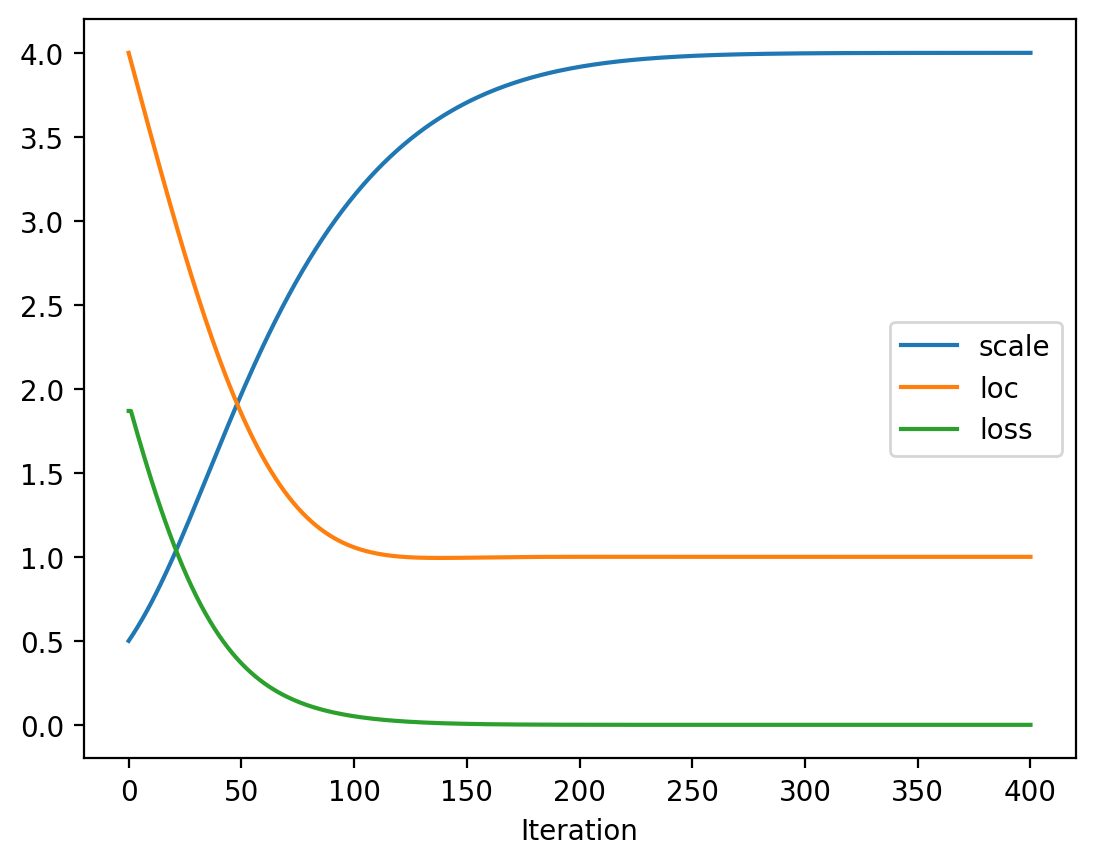

In [ ]:
plt.plot(torch.tensor(scale_array), label = 'scale')
plt.plot(torch.tensor(loc_array), label = 'loc')
plt.plot(torch.tensor(loss_array), label = 'loss')
plt.legend()
plt.xlabel("Iteration")

After training, we are able to recover the scale and loc very close to that of $p$

### Animation!

In [ ]:
def animate(i):
    fig = plt.figure(tight_layout=True, figsize=(8, 4))
    ax = fig.gca()    
    ax.clear()
    ax.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$", lw=5)
    to_learn_q = dist.Normal(loc = loc_array[i], scale=scale_array[i])
    loss = loss_array[i]
    loc = loc_array[i].item()
    scale = scale_array[i].item()
    ax.plot(
        z_values.numpy(),
        torch.exp(to_learn_q.log_prob(z_values)).numpy(),
        label=rf"$q\sim \mathcal{{N}}({loc:0.2f}, {scale:0.2f})$",
    )

    ax.set_title(rf"Iteration: {i}, $D_{{KL}}(q||p)$: {loss:0.2f}")
    ax.legend(bbox_to_anchor=(1.1, 1), borderaxespad=0)
    ax.set_ylim((0, 1))
    ax.set_xlim((-5, 15))

    ax.set_xlabel("x")
    ax.set_ylabel("PDF")
    sns.despine()
    
@interact(i=(0, len(loc_array) - 1))
def show_animation(i=0):
    animate(i)

interactive(children=(IntSlider(value=0, description='i', max=400), Output()), _dom_classes=('widget-interact'…

<!-- ![](ani1.gif) -->

### Finding the KL divergence for two distributions from different families

Let us rework our example with `p` coming from  a mixture of Gaussian distribution and `q` being Normal.

In [ ]:
p_s = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(probs=torch.tensor([0.5, 0.5])),
    component_distribution=dist.Normal(
        loc=torch.tensor([-0.2, 1]), scale=torch.tensor([0.4, 0.5])  # One for each component.
    ),
)  

p_s

MixtureSameFamily(
  Categorical(probs: torch.Size([2]), logits: torch.Size([2])),
  Normal(loc: torch.Size([2]), scale: torch.Size([2])))

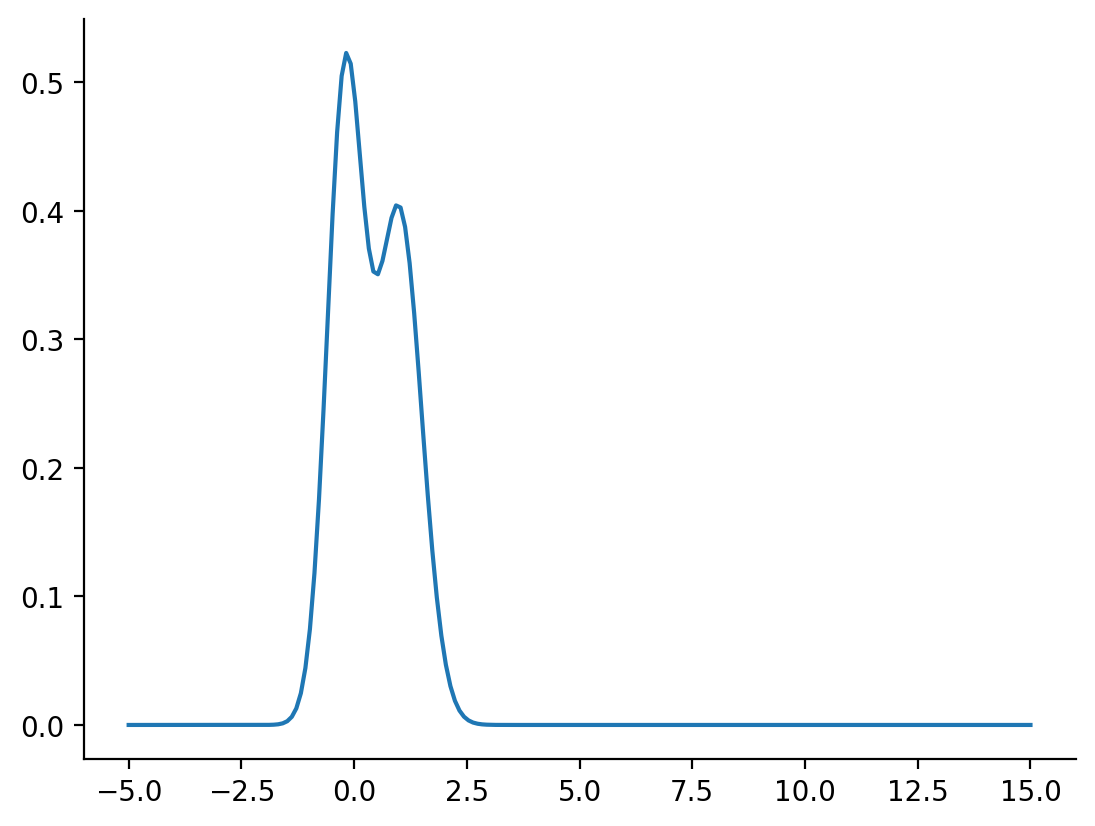

In [ ]:
plt.plot(z_values, torch.exp(p_s.log_prob(z_values)))
sns.despine()

Let us create two Normal distributions q_1 and q_2 and plot them to see which looks closer to p_s.

In [ ]:
q_1 = create_q(3, 1)
q_2 = create_q(3, 4.5)

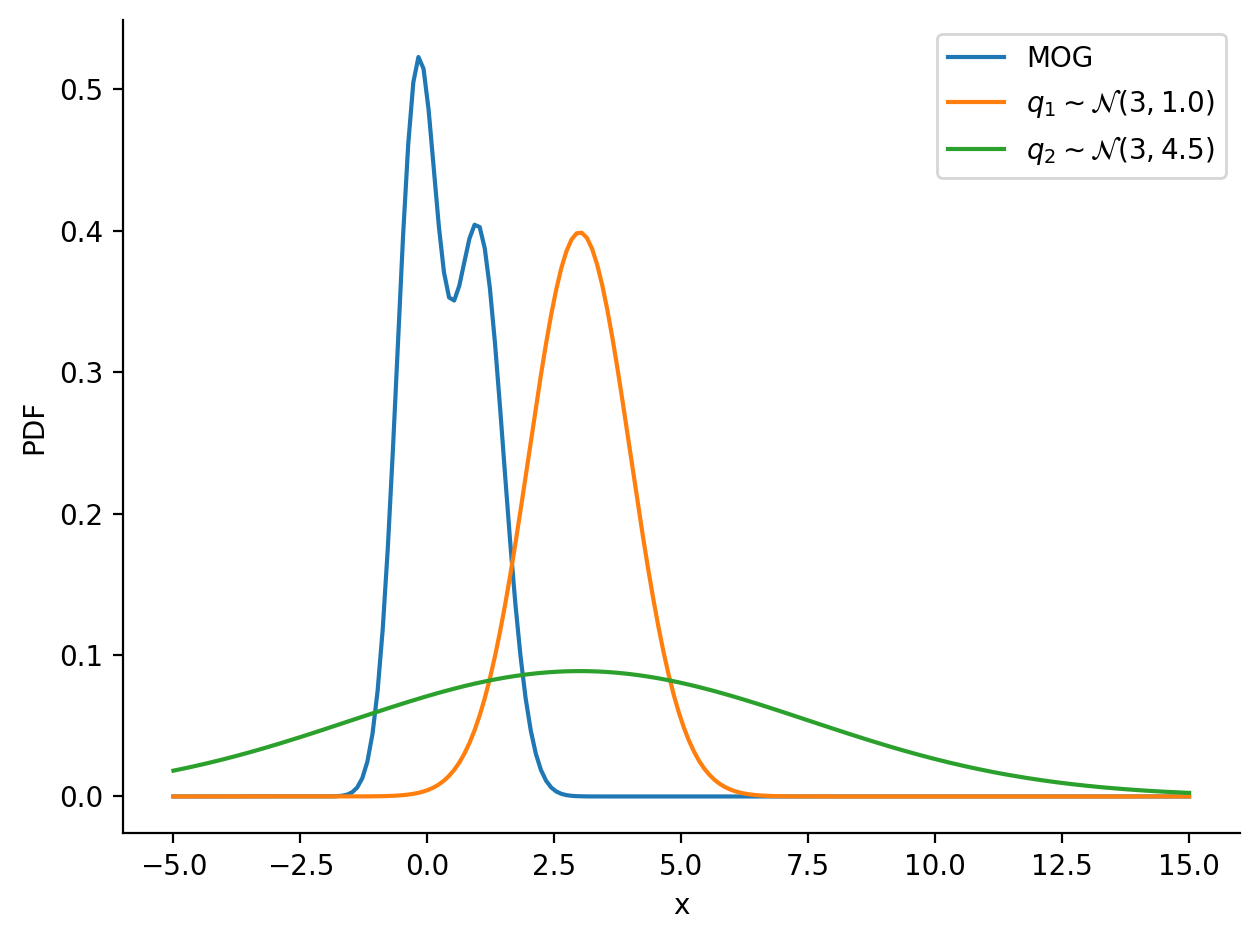

In [ ]:
prob_values_p_s = torch.exp(p_s.log_prob(z_values))
prob_values_q_1 = torch.exp(q_1.log_prob(z_values))
prob_values_q_2 = torch.exp(q_2.log_prob(z_values))

plt.plot(z_values, prob_values_p_s, label=r"MOG")
plt.plot(z_values, prob_values_q_1, label=r"$q_1\sim\mathcal{N} (3, 1.0)$")
plt.plot(z_values, prob_values_q_2, label=r"$q_2\sim\mathcal{N} (3, 4.5)$")

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")
plt.tight_layout()
plt.savefig(
    "dkl-different.png",
    dpi=150,
)

In [ ]:
try:
    dist.kl_divergence(q_1, p_s)
except NotImplementedError:
    print(f"KL divergence not implemented between {q_1.__class__} and {p_s.__class__}")

KL divergence not implemented between <class 'torch.distributions.normal.Normal'> and <class 'torch.distributions.mixture_same_family.MixtureSameFamily'>


As we see above, we can not compute the KL divergence directly. The core idea would now be to leverage the Monte Carlo sampling and generating the expectation. The following function does that.

In [ ]:
def kl_via_sampling(q, p, n_samples=100000):
    # Get samples from q
    sample_set = q.sample([n_samples])
    # Use the definition of KL-divergence
    return torch.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [ ]:
dist.kl_divergence(q_1, q_2)

tensor(1.0288)

In [ ]:
kl_via_sampling(q_1, q_2)

tensor(1.0285)

In [ ]:
kl_via_sampling(q_1, p_s), kl_via_sampling(q_2, p_s)

(tensor(9.5084), tensor(44.8863))

As we can see from KL divergence calculations, `q_1` is closer to our Gaussian mixture distribution.

### Optimizing the KL divergence for two distributions from different families



We saw that we can calculate the KL divergence between two different distribution families via sampling. But, as we did earlier, will we be able to optimize the parameters of our target surrogate distribution? The answer is No! As we have introduced sampling. However, there is still a way -- by reparameterization! 

Our surrogate q in this case is parameterized by `loc` and `scale`. The key idea here is to generate samples from a standard normal distribution (loc=0, scale=1) and then apply an affine transformation on the generated samples to get the samples generated from q. See my other post on sampling from normal distribution to understand this better.

The loss can now be thought of as a function of `loc` and `scale`.

### Backpropagation through sampling

#### Version 1: Default

In [ ]:
loc = torch.tensor(2.0, requires_grad=True)
scale = torch.tensor(0.5, requires_grad=True)
q = dist.Normal(loc, scale)
s = q.sample()
try:
    s.backward()
    print(f"Gradient of loc: {loc.grad}")
    print(f"Gradient of scale: {scale.grad}")
except Exception as e:
    print(f"Error: {e}")

Error: element 0 of tensors does not require grad and does not have a grad_fn


#### Version 2: Using the reparameterization trick manually

In [ ]:
torch.manual_seed(42)
std_normal = dist.Normal(0, 1)
loc = torch.tensor(2.0, requires_grad=True)
scale = torch.tensor(0.5, requires_grad=True)

eps = std_normal.sample()
z = loc + scale * eps
try:
    z.backward()
    print(f"Gradient of loc: {loc.grad}")
    print(f"Gradient of scale: {scale.grad}")
    print(f"Sample from standard normal: {eps}")
except Exception as e:
    print(f"Error: {e}")

Gradient of loc: 1.0
Gradient of scale: 0.33669036626815796
Sample from standard normal: 0.33669036626815796


#### Version 3: Using `rsample` instead of `sample`

In [ ]:
torch.manual_seed(42)

loc = torch.tensor(2.0, requires_grad=True)
scale = torch.tensor(0.5, requires_grad=True)
q = dist.Normal(loc, scale)
s = q.rsample()

try:
    s.backward()
    print(f"Gradient of loc: {loc.grad}")
    print(f"Gradient of scale: {scale.grad}")
except Exception as e:
    print(f"Error: {e}")

Gradient of loc: 1.0
Gradient of scale: 0.33669036626815796


### Original formulation (not differentiable)
![](../diagrams/reparam.001.png)

### Reparameterized formulation (differentiable)

![](../diagrams/reparam.002.png)

In [ ]:
n_samples = 5000

def original_loss_rsample(q, p_s):
    sample_set = q.rsample([n_samples])
    return torch.mean(q.log_prob(sample_set) - p_s.log_prob(sample_set))

def loss(q, p_s):
    loc = q.loc
    scale = q.scale
    
    std_normal = dist.Normal(loc=0.0, scale=1.0)
    sample_set = std_normal.sample([n_samples])
    sample_set = loc + scale * sample_set
    return torch.mean(q.log_prob(sample_set) - p_s.log_prob(sample_set))

Having defined the loss above, we can now optimize `loc` and `scale` to minimize the KL-divergence.

In [ ]:
def optimize_loc_scale(loss_fn):
    loc = 6.0
    scale = 0.1
    model = TrainableNormal(loc=loc, scale=scale)

    loc_array = [torch.tensor(loc)]
    scale_array = [torch.tensor(scale)]
    loss_array = [loss_fn(model(), p_s).item()]
    opt = torch.optim.Adam(model.parameters(), lr=0.05)
    epochs = 500
    for i in range(7):
        iter_losses, epoch_losses, state_dict_list = train_fn(model, inputs=None, outputs=p_s, loss_fn=loss_fn, optimizer=opt, epochs=epochs, verbose=False, get_state_dict=True)
        loss_array.extend(epoch_losses)
        loc_array.extend([state_dict["loc"] for state_dict in state_dict_list])
        scale_array.extend([torch.functional.F.softplus(state_dict["raw_scale"]) for state_dict in state_dict_list])

        print(
            f"Iteration: {i*epochs}, Loss: {epoch_losses[-1]:0.2f}, Loc: {loc_array[-1]:0.2f}, Scale: {scale_array[-1]:0.2f}"
        )
    
    return loc_array, scale_array, loss_array

In [ ]:
loc_array, scale_array, loss_array = optimize_loc_scale(original_loss_rsample)

Iteration: 0, Loss: 0.05, Loc: 0.43, Scale: 0.72
Iteration: 500, Loss: 0.06, Loc: 0.43, Scale: 0.72
Iteration: 1000, Loss: 0.05, Loc: 0.43, Scale: 0.72
Iteration: 1500, Loss: 0.05, Loc: 0.43, Scale: 0.72
Iteration: 2000, Loss: 0.06, Loc: 0.43, Scale: 0.71
Iteration: 2500, Loss: 0.05, Loc: 0.43, Scale: 0.72
Iteration: 3000, Loss: 0.06, Loc: 0.43, Scale: 0.74


In [ ]:
loc_array, scale_array, loss_array = optimize_loc_scale(loss)

Iteration: 0, Loss: 0.06, Loc: 0.43, Scale: 0.72
Iteration: 500, Loss: 0.07, Loc: 0.43, Scale: 0.72
Iteration: 1000, Loss: 0.06, Loc: 0.43, Scale: 0.71
Iteration: 1500, Loss: 0.05, Loc: 0.43, Scale: 0.73
Iteration: 2000, Loss: 0.05, Loc: 0.43, Scale: 0.70
Iteration: 2500, Loss: 0.06, Loc: 0.43, Scale: 0.71
Iteration: 3000, Loss: 0.05, Loc: 0.42, Scale: 0.72


In [ ]:
q_s = TrainableNormal(loc=loc_array[-1], scale=scale_array[-1])()
q_s

/tmp/ipykernel_932718/1037592773.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.loc = nn.Parameter(torch.tensor(loc))
/tmp/ipykernel_932718/1037592773.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  raw_scale = torch.log(torch.expm1(torch.tensor(scale)))


Normal(loc: Parameter containing:
tensor(0.4250, requires_grad=True), scale: 0.7164072394371033)

Text(0, 0.5, 'PDF')

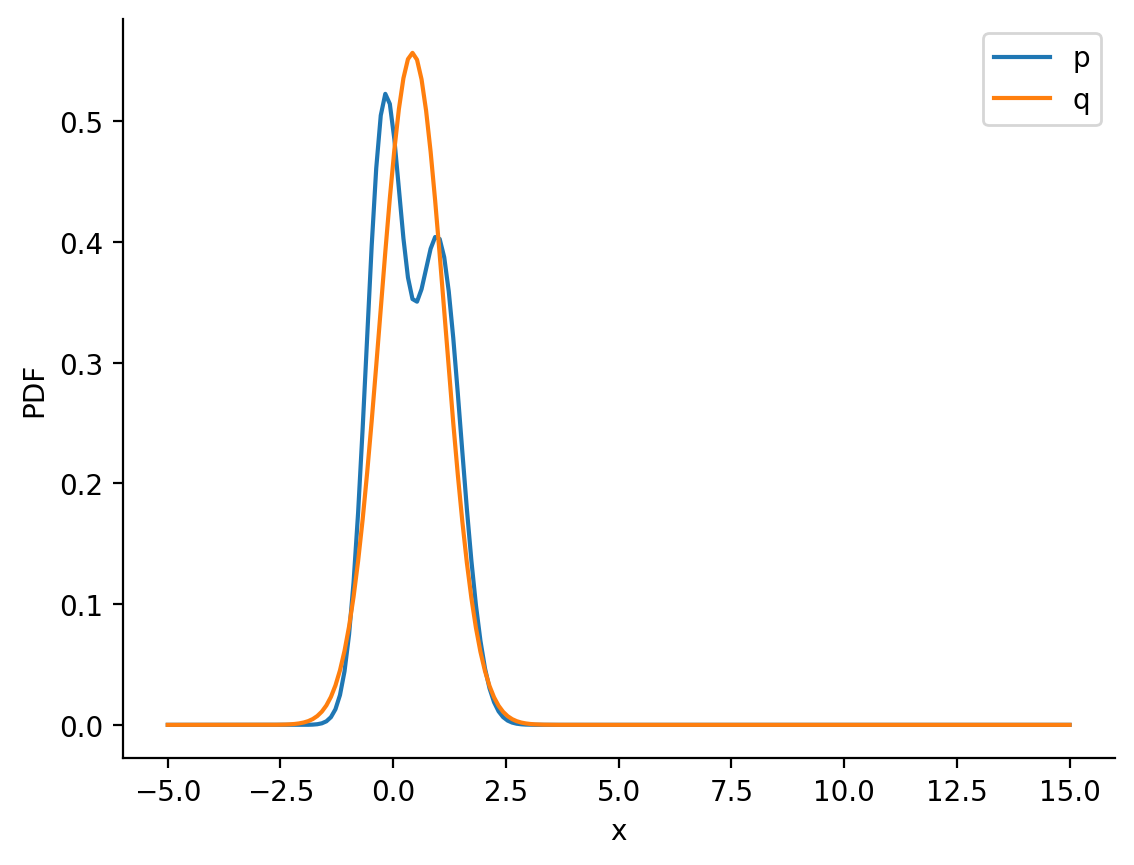

In [ ]:
prob_values_p_s = torch.exp(p_s.log_prob(z_values))
prob_values_q_s = torch.exp(q_s.log_prob(z_values))

plt.plot(z_values, prob_values_p_s.detach(), label=r"p")
plt.plot(z_values, prob_values_q_s.detach(), label=r"q")

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")

In [ ]:
prob_values_p_s = torch.exp(p_s.log_prob(z_values))

def a(iteration):
    fig = plt.figure(tight_layout=True, figsize=(8, 4))
    ax = fig.gca()

    loc = loc_array[iteration]
    scale = scale_array[iteration]
    q_s = dist.Normal(loc=loc, scale=scale)

    prob_values_q_s = torch.exp(q_s.log_prob(z_values))

    ax.plot(z_values, prob_values_p_s, label=r"p")
    ax.plot(z_values, prob_values_q_s, label=r"q")
    ax.set_title(f"Iteration {iteration}, Loss: {loss_array[iteration]:0.2f}")
    ax.set_ylim((-0.05, 1.05))
    ax.legend()
    sns.despine()

@interact(i=(0, len(loc_array) - 1))
def show_animation(i=0):
    return a(i)

interactive(children=(IntSlider(value=0, description='i', max=3500), Output()), _dom_classes=('widget-interact…

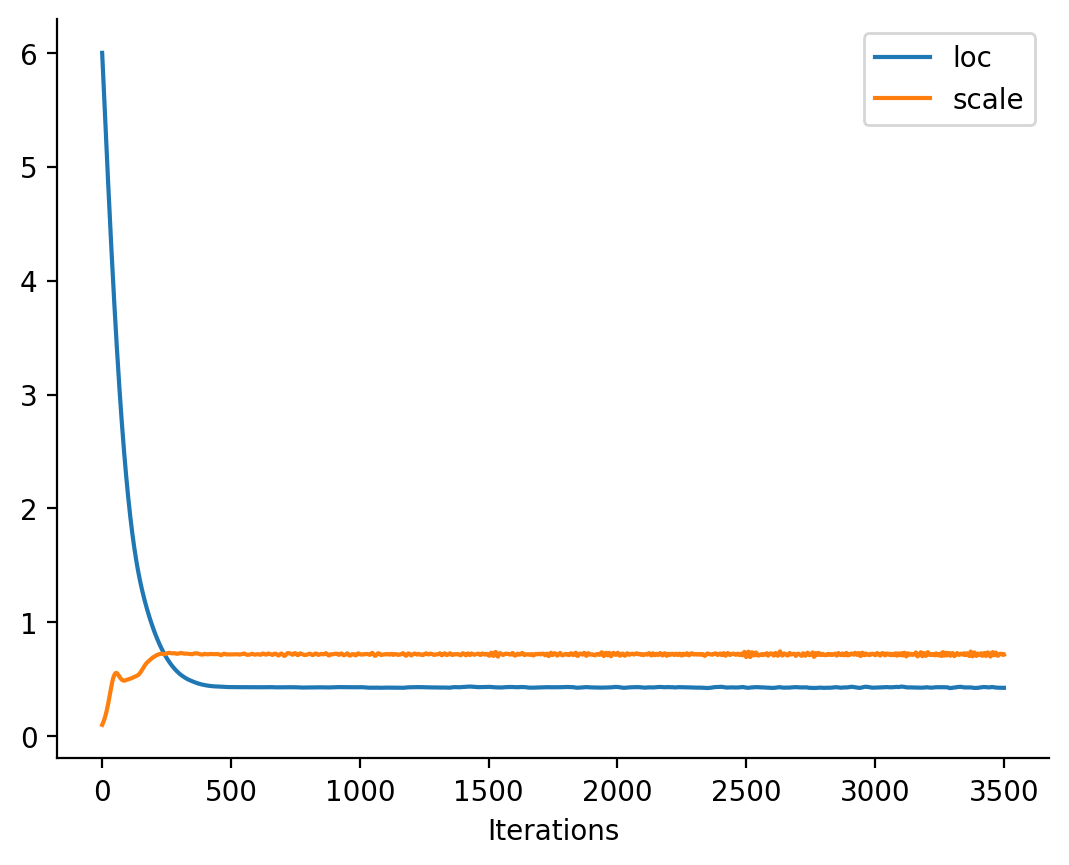

In [ ]:
plt.plot(loc_array, label="loc")
plt.plot(scale_array, label="scale")
plt.xlabel("Iterations")
sns.despine()
plt.legend()

![](kl_qp_mg.gif)

### ELBO

### Coin toss example

In [ ]:
def log_prior(theta):
    return dist.Beta(5, 3, validate_args=False).log_prob(theta)

def log_likelihood(theta, data):
    return dist.Bernoulli(theta, validate_args=False).log_prob(data).sum()

def log_joint(theta, data):
    return log_likelihood(theta, data) + log_prior(theta)

def true_log_posterior(theta, data):
    return dist.Beta(5 + data.sum(), 3 + len(data) - data.sum(), validate_args=False).log_prob(theta)

In [ ]:
theta_values = torch.linspace(0, 1, 200)

# Generate data: 17 heads out of 30 tosses
data = torch.ones(17)
data = torch.cat([data, torch.zeros(13)])
print(data.shape)

try:
    ll = log_likelihood(theta_values, data)
except Exception as e:
    print(f"Error: {e}")

torch.Size([30])
Error: The size of tensor a (200) must match the size of tensor b (30) at non-singleton dimension 0


In [ ]:
try:
    ll = torch.vmap(lambda theta: log_likelihood(theta, data))(theta_values)
except Exception as e:
    print(f"Error: {e}")

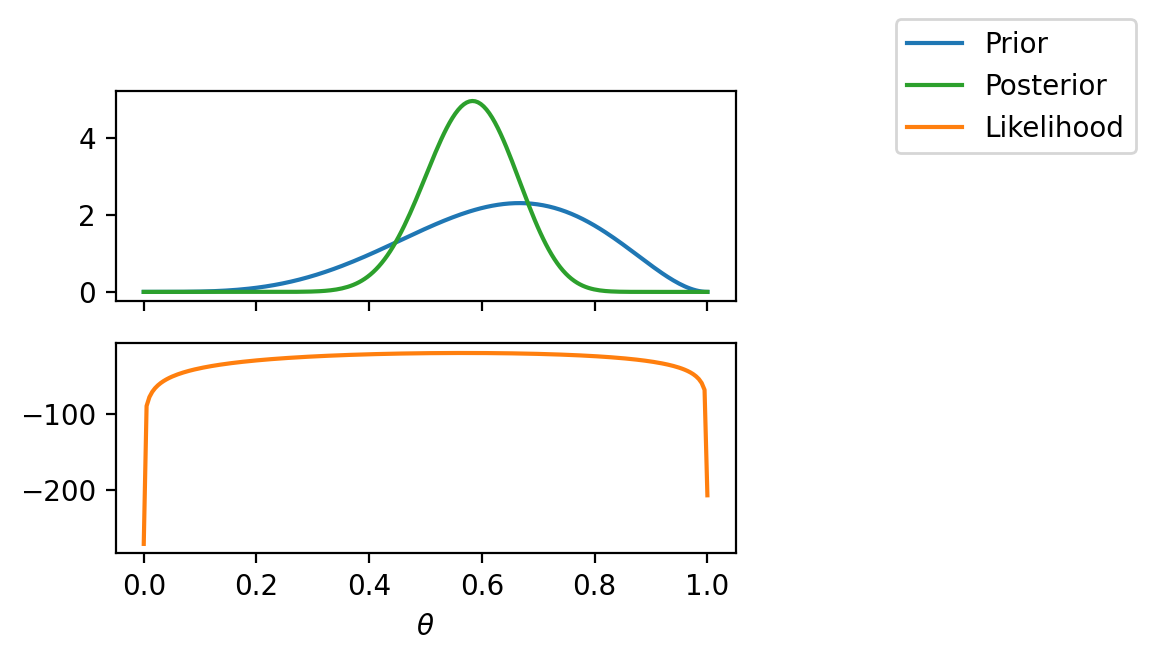

In [ ]:
# Plot prior
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(4, 3))
ax[0].plot(theta_values, torch.exp(log_prior(theta_values)), label="Prior", color="C0")

# Plot likelihood
ax[1].plot(theta_values, ll, label="Likelihood", color="C1")

# Plot posterior
ax[0].plot(theta_values, torch.exp(true_log_posterior(theta_values, data)), label="Posterior", color="C2")

ax[1].set_xlabel(r"$\theta$")
# Legend outside the plot
fig.legend(bbox_to_anchor=(1.4, 1), borderaxespad=0)

Now, let us create a target distribution `q` 

$$q(\theta) = \text{Beta}(\alpha, \beta)$$

In [ ]:
def neg_elbo(log_joint_fn, q, data, n_mc_samples=100):
    # Sample from q
    theta = q.rsample([n_mc_samples])
    # Compute the log probabilities
    log_q_theta = q.log_prob(theta)
    log_joint = torch.vmap(lambda theta: log_joint_fn(theta, data))(theta)
    # Compute ELBO as the difference of log probabilities
    # print(log_joint, log_q_theta)
    elbo = log_joint - log_q_theta
    return -elbo.mean()

In [ ]:
neg_elbo(log_joint, dist.Beta(0.1, 2), data=data)

tensor(188.3255)

In [ ]:
neg_elbo(log_joint, dist.Beta(5 + data.sum(), 3 + len(data) - data.sum()), data=data)

tensor(21.3972)

In [ ]:
alpha = 45.0
beta = 45.0

class TrainableBeta(AstraModel):
    def __init__(self, alpha, beta):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.beta = nn.Parameter(torch.tensor(beta))
        
    def forward(self, X=None):
        return dist.Beta(self.alpha, self.beta, validate_args=False)
    
def loss_fn(q, data):
    return neg_elbo(log_joint, q, data)

alpha_array = []
beta_array = []
loss_array = []

model = TrainableBeta(alpha, beta)
opt = torch.optim.Adam(model.parameters(), lr=0.05)

epochs = 400
for i in range(10):
    # opt.zero_grad()
    iter_losses, epoch_losses, state_dict_list = train_fn(model, inputs=None, outputs=data, loss_fn=loss_fn, optimizer=opt, epochs=epochs, verbose=False, get_state_dict=True)
    loss_array.extend(epoch_losses)
    alpha_array.extend([state_dict["alpha"] for state_dict in state_dict_list])
    beta_array.extend([state_dict["beta"] for state_dict in state_dict_list])

    print(model.alpha.item(), model.beta.item(), loss_array[-1])

50.1816520690918 36.34092330932617 21.476341247558594
46.14812469482422 33.25750732421875 21.511411666870117
40.37468719482422 29.252016067504883 21.441421508789062
33.6818962097168 24.60263442993164 21.424833297729492
28.15039825439453 20.374221801757812 21.403486251831055
24.588979721069336 17.69241714477539 21.386621475219727
22.943199157714844 16.783403396606445 21.397306442260742
22.690444946289062 16.28579330444336 21.395126342773438
22.122949600219727 16.065759658813477 21.39728355407715
22.082298278808594 16.358871459960938 21.411762237548828


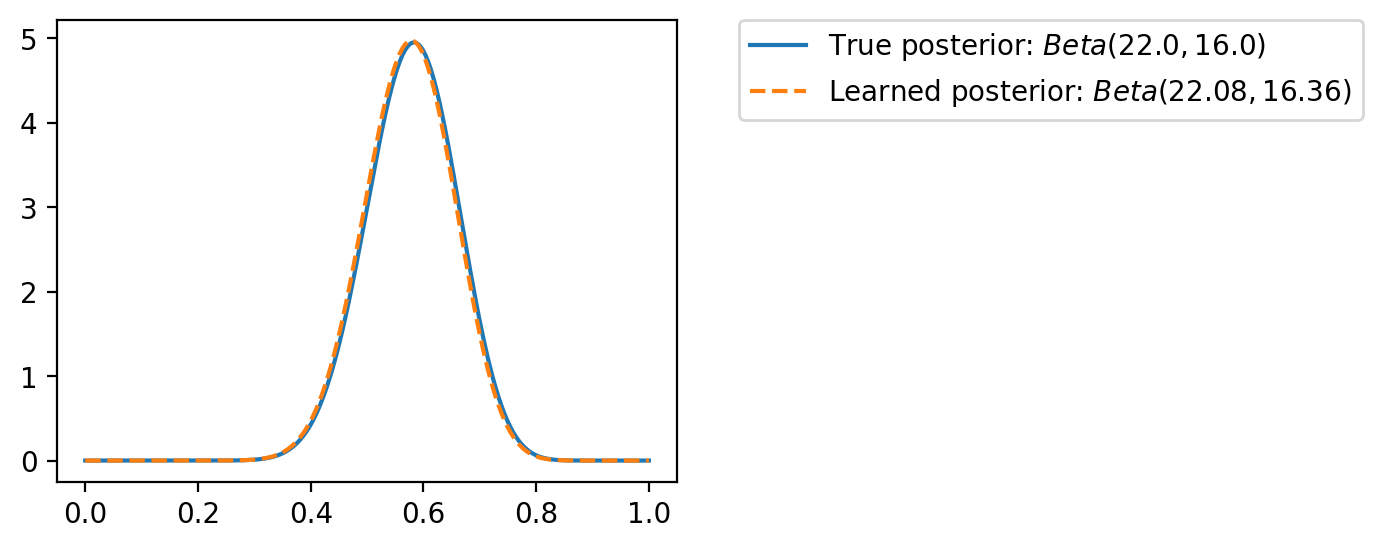

In [ ]:
# Plot the posterior with the true posterior
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
alpha = model.alpha.item()
beta = model.beta.item()

with torch.no_grad():
    q = model()
    ax.plot(theta_values, torch.exp(true_log_posterior(theta_values, data)), label=fr"True posterior: $Beta({data.sum()+5}, {len(data)+3-data.sum()})$")
    ax.plot(theta_values, torch.exp(q.log_prob(theta_values)), ls='--', label=fr"Learned posterior: $Beta({alpha:0.2f}, {beta:0.2f})$")
plt.legend(bbox_to_anchor=(1.1, 1), borderaxespad=0)

In [ ]:
import pyro
import pyro.distributions as py_dist
from pyro.infer import SVI, Trace_ELBO

def model(data):
    theta = pyro.sample("theta", py_dist.Beta(torch.tensor(5.0), torch.tensor(3.0)))
    with pyro.plate("data", len(data)):
        pyro.sample("obs", py_dist.Bernoulli(theta), obs=data)

def guide(data):
    alpha_q = pyro.param("alpha_q", torch.tensor(45.0))
    beta_q = pyro.param("beta_q", torch.tensor(45.0))
    pyro.sample("theta", py_dist.Beta(alpha_q, beta_q))
    
pyro.clear_param_store()

# Optimizer
adam_params = {"lr": 0.05}
optimizer = pyro.optim.Adam(adam_params)

# SVI
t = Trace_ELBO(num_particles=5)
svi = SVI(model, guide, optimizer, loss=t)

In [ ]:
t.num_particles

5

In [ ]:
svi = SVI(model, guide, optimizer, loss=t)
for step in range(8001):
    loss = svi.step(data)
    if step % 400 == 0:
        print(f"Step {step} | Loss: {loss:0.2f} | alpha: {pyro.param('alpha_q').item():0.2f} | beta: {pyro.param('beta_q').item():0.2f}")

Step 0 | Loss: 22.14 | alpha: 45.05 | beta: 44.95
Step 400 | Loss: 21.28 | alpha: 50.63 | beta: 36.37
Step 800 | Loss: 21.54 | alpha: 48.08 | beta: 34.31
Step 1200 | Loss: 21.31 | alpha: 44.80 | beta: 32.51
Step 1600 | Loss: 21.66 | alpha: 42.07 | beta: 30.25
Step 2000 | Loss: 21.50 | alpha: 38.86 | beta: 28.15
Step 2400 | Loss: 21.62 | alpha: 36.06 | beta: 26.31
Step 2800 | Loss: 21.48 | alpha: 33.20 | beta: 24.97
Step 3200 | Loss: 21.24 | alpha: 32.04 | beta: 22.67
Step 3600 | Loss: 21.52 | alpha: 30.25 | beta: 21.59
Step 4000 | Loss: 21.42 | alpha: 28.09 | beta: 21.34
Step 4400 | Loss: 21.35 | alpha: 27.72 | beta: 19.92
Step 4800 | Loss: 21.40 | alpha: 26.62 | beta: 19.03
Step 5200 | Loss: 21.46 | alpha: 25.96 | beta: 18.54
Step 5600 | Loss: 21.41 | alpha: 24.93 | beta: 18.18
Step 6000 | Loss: 21.46 | alpha: 24.90 | beta: 17.38
Step 6400 | Loss: 21.39 | alpha: 24.43 | beta: 17.72
Step 6800 | Loss: 21.36 | alpha: 24.09 | beta: 17.65
Step 7200 | Loss: 21.38 | alpha: 23.80 | beta: 17.2

In [ ]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

In [ ]:
alpha_q, beta_q

(23.228673934936523, 16.67105484008789)

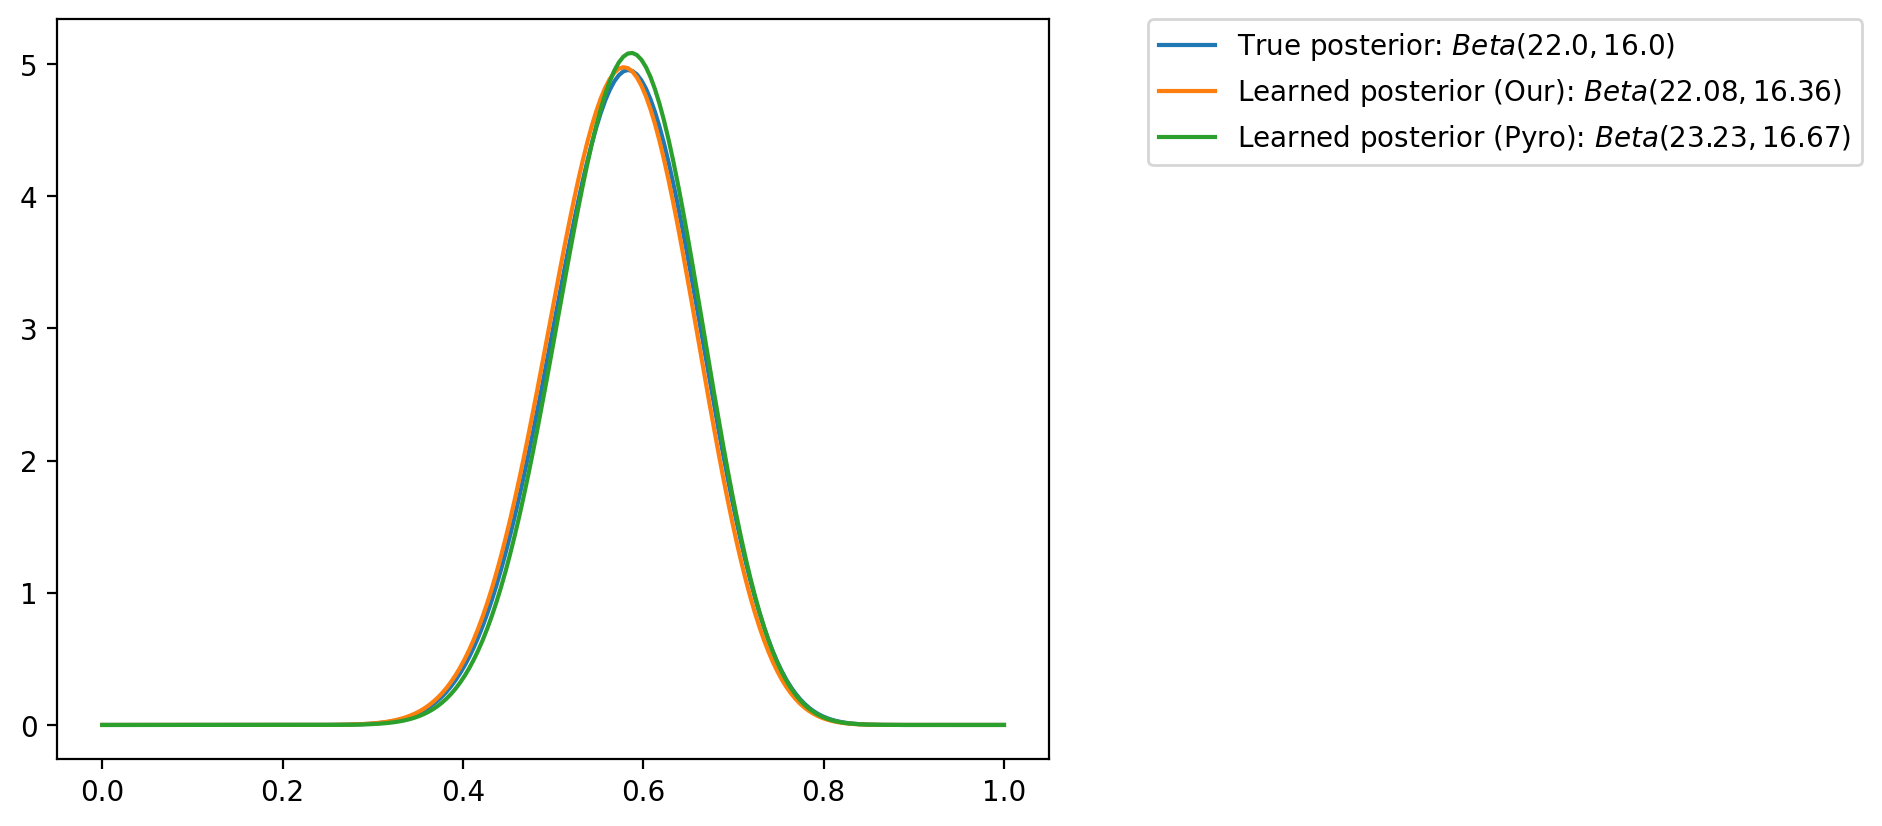

In [ ]:
plt.plot(theta_values, torch.exp(true_log_posterior(theta_values, data)), label=fr"True posterior: $Beta({data.sum()+5}, {len(data)+3-data.sum()})$")
plt.plot(theta_values, torch.exp(q.log_prob(theta_values)), label=fr"Learned posterior (Our): $Beta({alpha:0.2f}, {beta:0.2f})$")
plt.plot(theta_values, torch.exp(py_dist.Beta(alpha_q, beta_q).log_prob(theta_values)), label=fr"Learned posterior (Pyro): $Beta({alpha_q:0.2f}, {beta_q:0.2f})$")
# legend outside the plot
plt.legend(bbox_to_anchor=(1.1, 1), borderaxespad=0)

### Linear regression

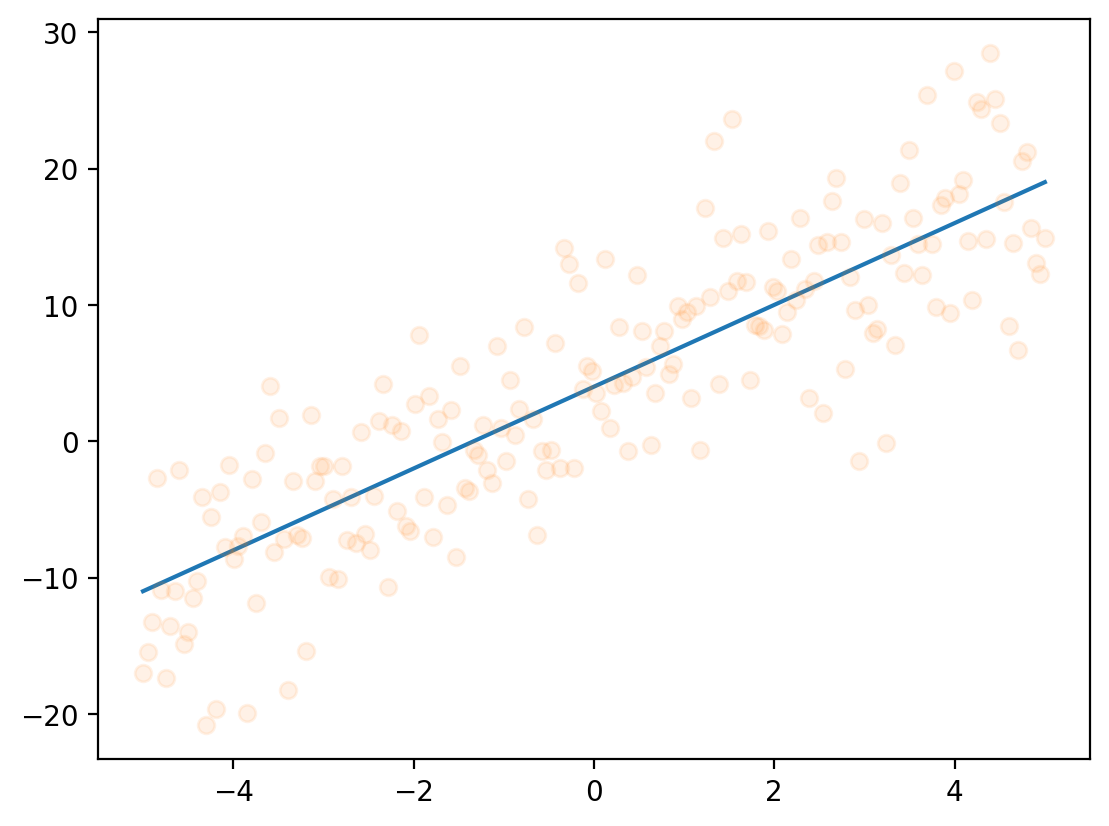

In [ ]:
N = 200
x_lin = torch.linspace(-5, 5, N)

f_true = lambda x: 3*x + 4

eps = 5*dist.Normal(0, 1).sample([N])

y = f_true(x_lin) + eps

plt.plot(x_lin, f_true(x_lin), label=r"$f(x)$")
plt.plot(x_lin, y, "o", label=r"$y$", alpha=0.1)

In [ ]:
def log_prior(theta):
    return dist.MultivariateNormal(torch.zeros(2), 
                                   torch.eye(2),
                                   validate_args=False).log_prob(theta)

def log_likelihood(theta, x, y):
    return dist.MultivariateNormal(theta[0] + theta[1] * x, torch.eye(N),
                                   validate_args=False).log_prob(y).sum()

def log_joint(theta, x, y):
    return log_likelihood(theta, x, y) + log_prior(theta)



In [ ]:
log_prior(torch.tensor([0.0, 0.0]))

tensor(-1.8379)

In [ ]:
log_likelihood(torch.tensor([0.0, 0.0]), x_lin, y), log_likelihood(torch.tensor([4.0, 3.0]), x_lin, y)

(tensor(-12662.5801), tensor(-3094.5022))

In [ ]:
def neg_elbo_x_y(log_joint_fn, q, x, y, n_mc_samples=100):
    # Sample from q
    theta = q.rsample([n_mc_samples])
    # Compute the log probabilities
    log_q_theta = q.log_prob(theta).sum(dim=-1)
    log_joint = torch.vmap(lambda theta: log_joint_fn(theta, x, y))(theta)
    # Compute ELBO as the difference of log probabilities
    # print(log_joint.shape, log_q_theta.shape)
    elbo = log_joint - log_q_theta
    return -elbo.mean()

In [ ]:
neg_elbo_x_y(log_joint, dist.MultivariateNormal(torch.zeros(2), torch.eye(2), validate_args=False), x_lin, y)

tensor(14002.7402)

In [ ]:
class LearnableNormal(AstraModel):
    def __init__(self, loc, scale):
        super().__init__()
        self.loc = nn.Parameter(torch.tensor(loc))
        raw_scale = torch.log(torch.expm1(torch.tensor(scale)))
        self.raw_scale = nn.Parameter(raw_scale)
            
    def forward(self, X=None):
        scale = torch.functional.F.softplus(self.raw_scale)
        return dist.Normal(self.loc, scale)
    
    def __repr__(self):
        return f"LearnableNormal(loc={self.loc.item():0.2f}, scale={torch.functional.F.softplus(self.raw_scale).item():0.2f})"
    
def loss_fn(q, data):
    x, y = data
    return neg_elbo_x_y(log_joint, q, x, y)

loc_array = []
scale_array = []
loss_array = []
model = LearnableNormal(loc=[0.0, 0.0], scale=[1.0, 1.0])
opt = torch.optim.Adam(model.parameters(), lr=0.05)

epochs = 400
for i in range(10):
    iter_losses, epoch_losses, state_dict_list = train_fn(model, inputs=None, outputs=(x_lin, y), loss_fn=loss_fn, optimizer=opt, epochs=epochs, verbose=False, get_state_dict=True)
    loss_array.extend(epoch_losses)
    loc_array.extend([state_dict["loc"] for state_dict in state_dict_list])
    scale_array.extend([torch.functional.F.softplus(state_dict["raw_scale"]) for state_dict in state_dict_list])

    print(
        f"Iteration: {i*epochs}, Loss: {epoch_losses[-1]:0.2f}, Loc: {loc_array[-1]}, Scale: {scale_array[-1]}"
    )
    

Iteration: 0, Loss: 3110.80, Loc: tensor([3.9938, 3.0722]), Scale: tensor([0.0824, 0.0701])
Iteration: 400, Loss: 3109.20, Loc: tensor([3.9973, 3.0746]), Scale: tensor([0.0709, 0.0430])
Iteration: 800, Loss: 3108.94, Loc: tensor([3.9965, 3.0742]), Scale: tensor([0.0708, 0.0334])
Iteration: 1200, Loss: 3108.87, Loc: tensor([3.9946, 3.0737]), Scale: tensor([0.0707, 0.0287])
Iteration: 1600, Loss: 3108.85, Loc: tensor([3.9950, 3.0726]), Scale: tensor([0.0705, 0.0264])
Iteration: 2000, Loss: 3108.84, Loc: tensor([3.9965, 3.0734]), Scale: tensor([0.0714, 0.0252])
Iteration: 2400, Loss: 3108.84, Loc: tensor([3.9962, 3.0738]), Scale: tensor([0.0711, 0.0246])
Iteration: 2800, Loss: 3108.84, Loc: tensor([3.9922, 3.0735]), Scale: tensor([0.0702, 0.0244])
Iteration: 3200, Loss: 3108.85, Loc: tensor([3.9932, 3.0727]), Scale: tensor([0.0712, 0.0244])
Iteration: 3600, Loss: 3108.84, Loc: tensor([3.9955, 3.0741]), Scale: tensor([0.0720, 0.0243])


torch.Size([1000, 2])


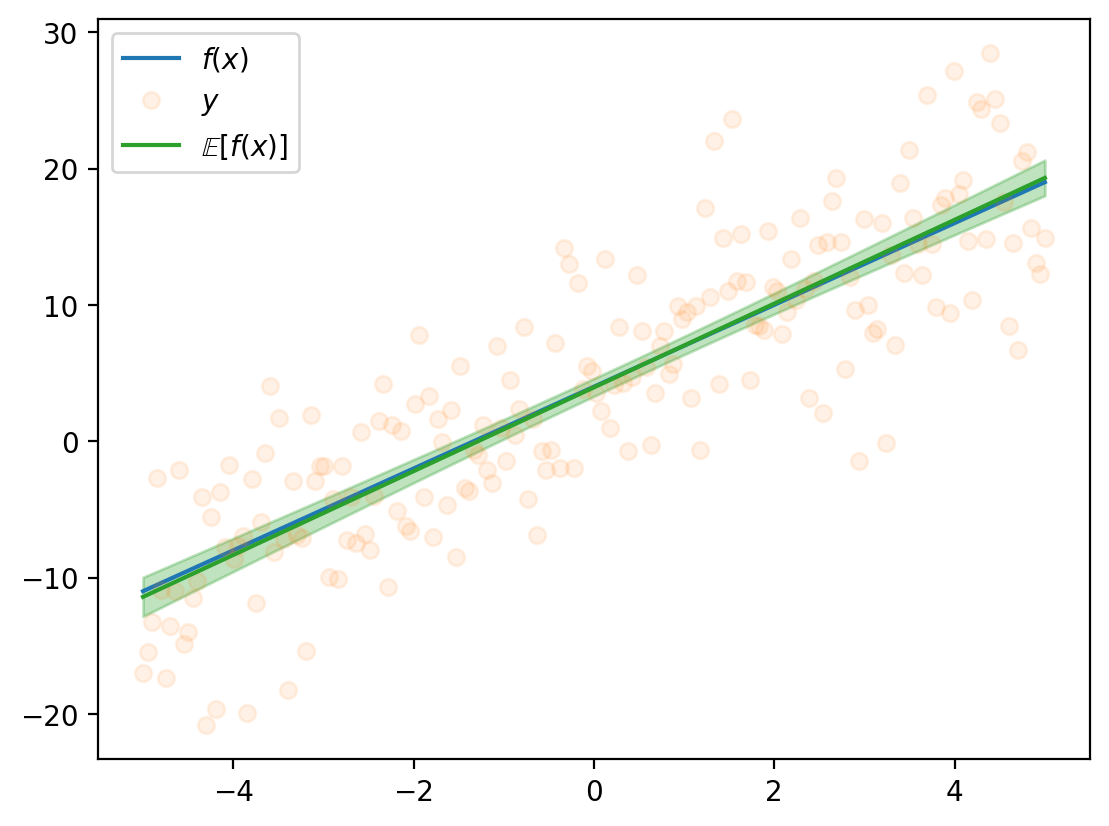

In [ ]:
# Predictive distribution using the learned posterior

n_samples = 1000
q = model()
q_samples = q.sample([n_samples])
print(q_samples.shape)
plt.plot(x_lin, f_true(x_lin), label=r"$f(x)$")
plt.plot(x_lin, y, "o", label=r"$y$", alpha=0.1)

y_hats = []
for i in range(n_samples):
    y_hat = q_samples[i, 0] + q_samples[i, 1] * x_lin
    y_hats.append(y_hat)

y_hat_mean = torch.stack(y_hats).mean(0)
y_hat_std = torch.stack(y_hats).std(0)

plt.plot(x_lin, y_hat_mean, label=r"$\mathbb{E}[f(x)]$", color='C2')
plt.fill_between(x_lin, y_hat_mean - y_hat_std, y_hat_mean + y_hat_std, alpha=0.3, color='C2')
plt.legend()

#### Learning the full covariance matrix

Reference: 
1. https://ericmjl.github.io/notes/stats-ml/estimating-a-multivariate-gaussians-parameters-by-gradient-descent/

In [ ]:
class LearnableMVN(AstraModel):
    def __init__(self, loc, log_L_flat):
        super().__init__()
        self.loc = nn.Parameter(loc)
        self.log_L_flat = nn.Parameter(log_L_flat)
            
    def forward(self, X=None):
        L = torch.reshape(self.log_L_flat, (2, 2))
        U = torch.triu(L)
        cov = U@U.T
        return dist.MultivariateNormal(self.loc, cov)
    
    def __repr__(self):
        return f"LearnableMVN(loc={self.loc.item():0.2f}, log_L_flat={self.log_L_flat.item():0.2f})"

loc_array = []
cov_array = []
loss_array = []

model = LearnableMVN(loc=torch.tensor([0.0, 0.0]), log_L_flat=torch.tensor([0.1, 0.1, 0.1, 0.1]))
opt = torch.optim.Adam(model.parameters(), lr=0.05)

epochs = 400
for i in range(6):
    iter_losses, epoch_losses, state_dict_list = train_fn(model, inputs=None, outputs=(x_lin, y), loss_fn=loss_fn, optimizer=opt, epochs=epochs, verbose=False, get_state_dict=True)
    loss_array.extend(epoch_losses)
    loc_array.extend([state_dict["loc"] for state_dict in state_dict_list])
    cov_array.extend([state_dict["log_L_flat"] for state_dict in state_dict_list])

    L = torch.reshape(cov_array[-1], (2, 2))
    cov = L@L.T
    print(
        f"Iteration: {i*epochs}, Loss: {epoch_losses[-1]:0.2f}, Loc: {loc_array[-1]}, Cov: {cov}"
    )

Iteration: 0, Loss: 3096.05, Loc: tensor([3.9907, 3.0739]), Cov: tensor([[0.4796, 0.0725],
        [0.0725, 0.0811]])
Iteration: 400, Loss: 3097.47, Loc: tensor([3.9900, 3.0810]), Cov: tensor([[0.5122, 0.0762],
        [0.0762, 0.0736]])
Iteration: 800, Loss: 3096.71, Loc: tensor([4.0127, 3.0732]), Cov: tensor([[0.4462, 0.0592],
        [0.0592, 0.0659]])
Iteration: 1200, Loss: 3097.79, Loc: tensor([4.0036, 3.0657]), Cov: tensor([[0.4887, 0.0808],
        [0.0808, 0.0708]])
Iteration: 1600, Loss: 3098.27, Loc: tensor([3.9980, 3.0683]), Cov: tensor([[0.5067, 0.0900],
        [0.0900, 0.0704]])
Iteration: 2000, Loss: 3097.97, Loc: tensor([3.9915, 3.0781]), Cov: tensor([[0.4511, 0.0562],
        [0.0562, 0.0700]])


torch.Size([1000, 2])


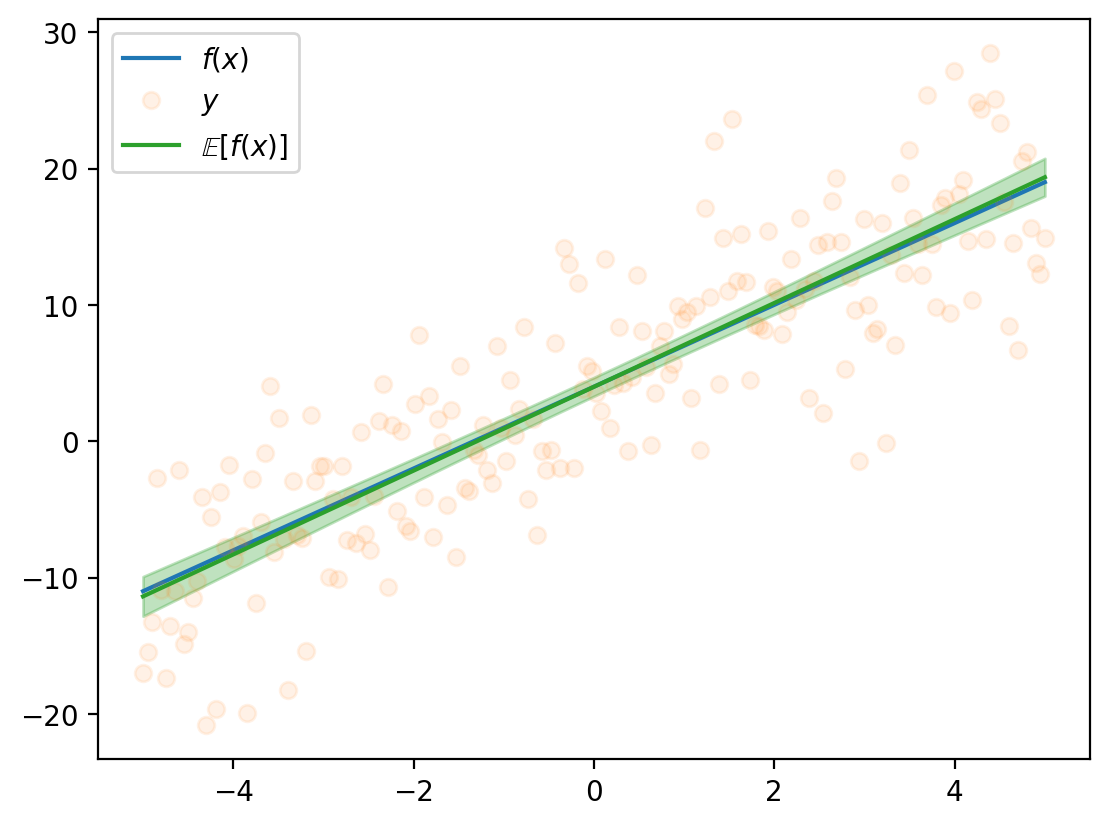

In [ ]:
# Predictive distribution using the learned posterior

n_samples = 1000
q = model()
q_samples = q.sample([n_samples])
print(q_samples.shape)
plt.plot(x_lin, f_true(x_lin), label=r"$f(x)$")
plt.plot(x_lin, y, "o", label=r"$y$", alpha=0.1)

y_hats = []
for i in range(n_samples):
    y_hat = q_samples[i, 0] + q_samples[i, 1] * x_lin
    y_hats.append(y_hat)

y_hat_mean = torch.stack(y_hats).mean(0)
y_hat_std = torch.stack(y_hats).std(0)

plt.plot(x_lin, y_hat_mean, label=r"$\mathbb{E}[f(x)]$", color='C2')
plt.fill_between(x_lin, y_hat_mean - y_hat_std, y_hat_mean + y_hat_std, alpha=0.3, color='C2')
plt.legend()


In [ ]:
# This is intentional stop here
asdjasndjka

NameError: name 'asdjasndjka' is not defined

## Stochastic VI [TODO]

### When data is large

We can use stochastic gradient descent to optimize the ELBO. We can use the following formula to compute the gradient of the ELBO.




Now, given our linear regression problem setup, we want to maximize the ELBO.

We can do so by the following. As a simple example, let us assume $\theta \in R^2$

- Assume some q. Say, a Normal distribution. So, $q\sim \mathcal{N}_2$
- Draw samples from q. Say N samples. 
- Initilize ELBO = 0.0
- For each sample:
    - Let us assume drawn sample is $[\theta_1, \theta_2]^T$
    - Compute log_prob of prior on $[\theta_1, \theta_2]^T$ or `lp = p.log_prob(θ1, θ2)`
    - Compute log_prob of likelihood on $[\theta_1, \theta_2]^T$ or `ll = l.log_prob(θ1, θ2)`
    - Compute log_prob of q on $[\theta_1, \theta_2]^T$ or `lq = q.log_prob(θ1, θ2)`
    - ELBO = ELBO + (ll+lp-q)
- Return ELBO/N

In [ ]:
prior = dist.Normal(loc = 0., scale = 1.)
p = dist.Normal(loc = 5., scale = 1.)

In [ ]:
samples = p.sample([1000])

In [ ]:
mu = torch.tensor(1.0, requires_grad=True)

def surrogate_sample(mu):
    std_normal = dist.Normal(loc = 0., scale=1.)
    sample_std_normal  = std_normal.sample()
    return mu + sample_std_normal


In [ ]:
samples_from_surrogate = surrogate_sample(mu)

In [ ]:
samples_from_surrogate

tensor(0.1894, grad_fn=<AddBackward0>)

In [ ]:
def logprob_prior(mu):
    return prior.log_prob(mu)

lp = logprob_prior(samples_from_surrogate)

def log_likelihood(mu, samples):
    di = dist.Normal(loc=mu, scale=1)
    return torch.sum(di.log_prob(samples))

ll = log_likelihood(samples_from_surrogate, samples)

ls = surrogate.log_prob(samples_from_surrogate)



In [ ]:
def elbo_loss(mu, data_samples):
    samples_from_surrogate = surrogate_sample(mu)
    lp = logprob_prior(samples_from_surrogate)
    ll = log_likelihood(samples_from_surrogate, data_samples)
    ls = surrogate.log_prob(samples_from_surrogate)

    return -lp - ll + ls

In [ ]:
mu = torch.tensor(1.0, requires_grad=True)

loc_array = []
loss_array = []

opt = torch.optim.Adam([mu], lr=0.02)
for i in range(2000):
    loss_val = elbo_loss(mu, samples)
    loss_val.backward()
    loc_array.append(mu.item())
    loss_array.append(loss_val.item())

    if i % 100 == 0:
        print(
            f"Iteration: {i}, Loss: {loss_val.item():0.2f}, Loc: {mu.item():0.3f}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 11693.85, Loc: 1.000
Iteration: 100, Loss: 2550.90, Loc: 2.744
Iteration: 200, Loss: 2124.30, Loc: 3.871
Iteration: 300, Loss: 2272.48, Loc: 4.582
Iteration: 400, Loss: 2025.17, Loc: 4.829
Iteration: 500, Loss: 1434.45, Loc: 5.079
Iteration: 600, Loss: 1693.33, Loc: 5.007
Iteration: 700, Loss: 1495.89, Loc: 4.957
Iteration: 800, Loss: 2698.28, Loc: 5.149
Iteration: 900, Loss: 2819.85, Loc: 5.117
Iteration: 1000, Loss: 1491.79, Loc: 5.112
Iteration: 1100, Loss: 1767.87, Loc: 4.958
Iteration: 1200, Loss: 1535.30, Loc: 4.988
Iteration: 1300, Loss: 1458.61, Loc: 4.949
Iteration: 1400, Loss: 1400.21, Loc: 4.917
Iteration: 1500, Loss: 2613.42, Loc: 5.073
Iteration: 1600, Loss: 1411.46, Loc: 4.901
Iteration: 1700, Loss: 1587.94, Loc: 5.203
Iteration: 1800, Loss: 1461.40, Loc: 5.011
Iteration: 1900, Loss: 1504.93, Loc: 5.076


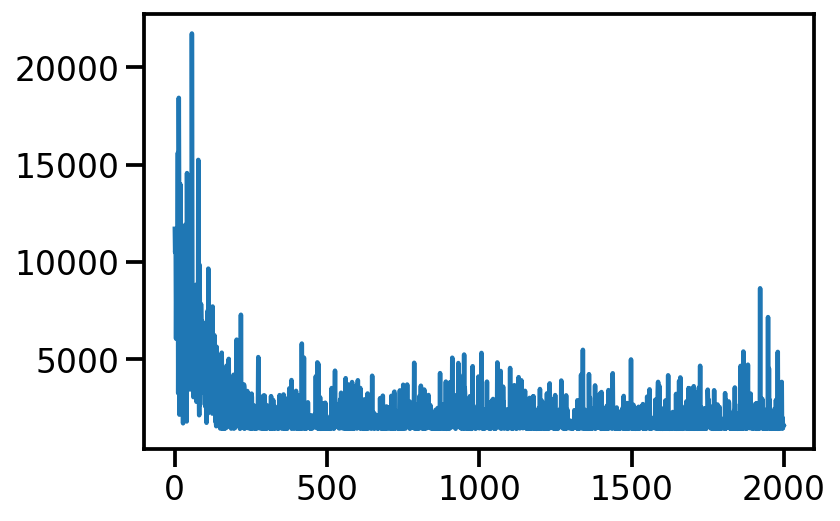

In [ ]:
plt.plot(loss_array)

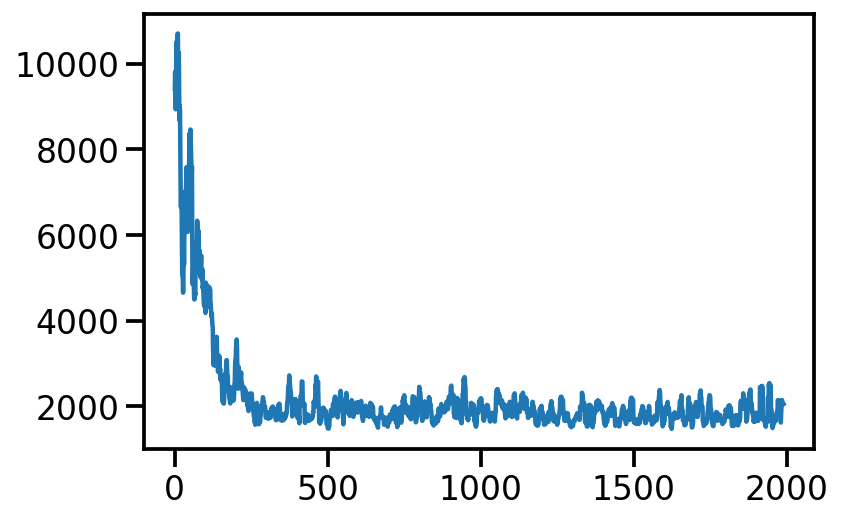

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view
plt.plot(np.average(sliding_window_view(loss_array, window_shape = 10), axis=1))

#### Linear Regression



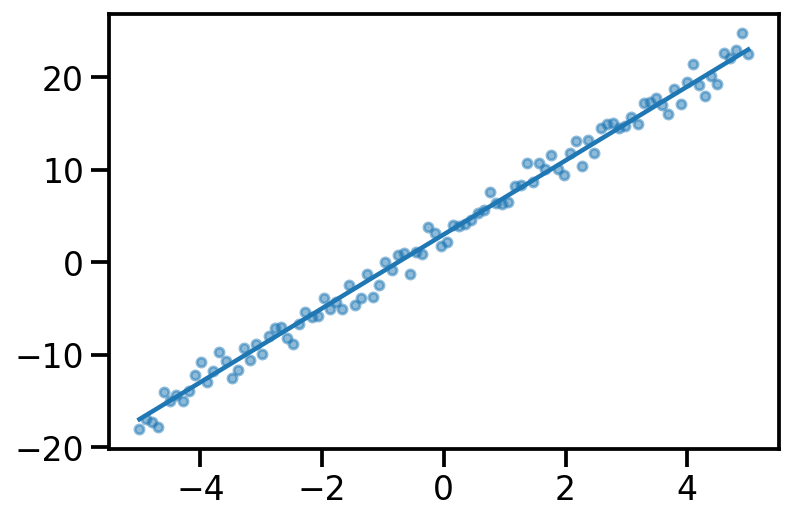

In [ ]:
true_theta_0 = 3.
true_theta_1 = 4.

x = torch.linspace(-5, 5, 100)
y_true = true_theta_0 + true_theta_1*x
y_noisy = y_true + torch.normal(mean = torch.zeros_like(x), std = torch.ones_like(x))

plt.plot(x, y_true)
plt.scatter(x, y_noisy, s=20, alpha=0.5)

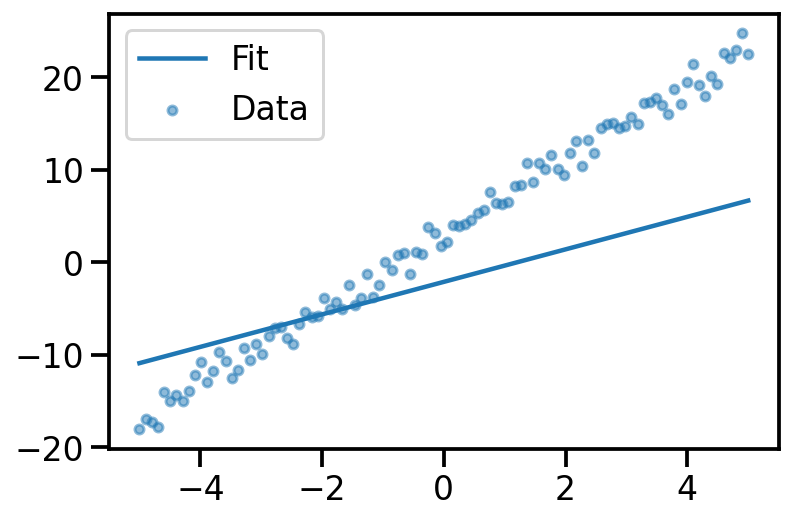

In [ ]:
y_pred = x_dash@theta_prior.sample()
plt.plot(x, y_pred, label="Fit")
plt.scatter(x, y_noisy, s=20, alpha=0.5, label='Data')
plt.legend()

In [ ]:
theta_prior = dist.MultivariateNormal(loc = torch.tensor([0., 0.]), covariance_matrix=torch.eye(2))


def likelihood(theta, x, y):
    x_dash = torch.vstack((torch.ones_like(x), x)).t()
    d = dist.Normal(loc=x_dash@theta, scale=torch.ones_like(x))
    return torch.sum(d.log_prob(y))

In [ ]:
likelihood(theta_prior.sample(), x, y_noisy)

tensor(-3558.0769)

In [ ]:
loc = torch.tensor([-1., 1.], requires_grad=True)
surrogate_mvn = dist.MultivariateNormal(loc = loc, covariance_matrix=torch.eye(2))
surrogate_mvn

MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))

In [ ]:
surrogate_mvn.sample()

tensor([-1.1585,  2.6212])

In [ ]:
def surrogate_sample_mvn(loc):
    std_normal_mvn = dist.MultivariateNormal(loc = torch.zeros_like(loc), covariance_matrix=torch.eye(loc.shape[0]))
    sample_std_normal  = std_normal_mvn.sample()
    return loc + sample_std_normal


In [ ]:
def elbo_loss(loc, x, y):
    samples_from_surrogate_mvn = surrogate_sample_mvn(loc)
    lp = theta_prior.log_prob(samples_from_surrogate_mvn)
    ll = likelihood(samples_from_surrogate_mvn, x, y_noisy)
    ls = surrogate_mvn.log_prob(samples_from_surrogate_mvn)

    return -lp - ll + ls

In [ ]:
loc.shape, x.shape, y_noisy.shape

(torch.Size([2]), torch.Size([100]), torch.Size([100]))

In [ ]:
elbo_loss(loc, x, y_noisy)

tensor(2850.3154, grad_fn=<AddBackward0>)

In [ ]:
loc = torch.tensor([-1., 1.], requires_grad=True)


loc_array = []
loss_array = []

opt = torch.optim.Adam([loc], lr=0.02)
for i in range(10000):
    loss_val = elbo_loss(loc, x, y_noisy)
    loss_val.backward()
    loc_array.append(mu.item())
    loss_array.append(loss_val.item())

    if i % 1000 == 0:
        print(
            f"Iteration: {i}, Loss: {loss_val.item():0.2f}, Loc: {loc}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 5479.97, Loc: tensor([-1.,  1.], requires_grad=True)
Iteration: 1000, Loss: 566.63, Loc: tensor([2.9970, 4.0573], requires_grad=True)
Iteration: 2000, Loss: 362.19, Loc: tensor([2.9283, 3.9778], requires_grad=True)
Iteration: 3000, Loss: 231.23, Loc: tensor([2.8845, 4.1480], requires_grad=True)
Iteration: 4000, Loss: 277.94, Loc: tensor([2.9284, 3.9904], requires_grad=True)
Iteration: 5000, Loss: 1151.51, Loc: tensor([2.9620, 4.0523], requires_grad=True)
Iteration: 6000, Loss: 582.19, Loc: tensor([2.8003, 4.0540], requires_grad=True)
Iteration: 7000, Loss: 178.48, Loc: tensor([2.8916, 3.9968], requires_grad=True)
Iteration: 8000, Loss: 274.76, Loc: tensor([3.0807, 4.1957], requires_grad=True)
Iteration: 9000, Loss: 578.37, Loc: tensor([2.9830, 4.0174], requires_grad=True)


In [ ]:
learnt_surrogate = dist.MultivariateNormal(loc = loc, covariance_matrix=torch.eye(2))

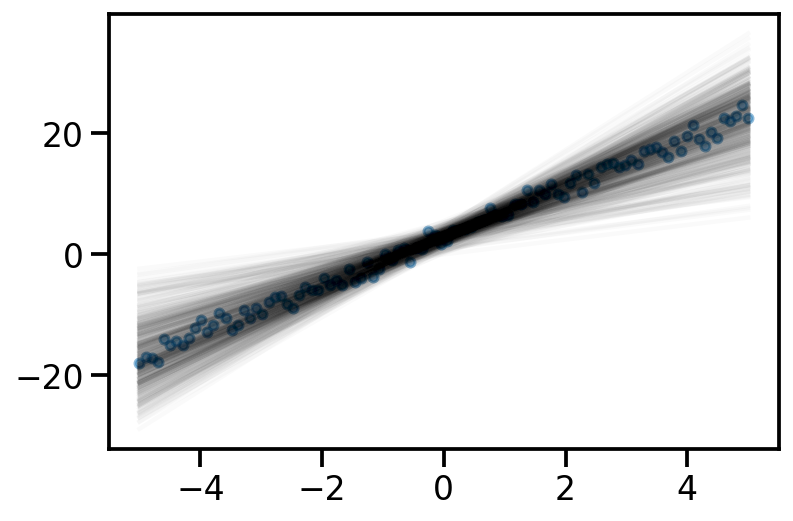

In [ ]:
y_samples_surrogate = x_dash@learnt_surrogate.sample([500]).t()
plt.plot(x, y_samples_surrogate, alpha = 0.02, color='k');
plt.scatter(x, y_noisy, s=20, alpha=0.5)

In [ ]:
x_dash@learnt_surrogate.loc.detach().t()
theta_sd = torch.linalg.cholesky(learnt_surrogate.covariance_matrix)


#y_samples_surrogate = x_dash@learnt_surrogate.loc.t()
#plt.plot(x, y_samples_surrogate, alpha = 0.02, color='k');
#plt.scatter(x, y_noisy, s=20, alpha=0.5)

tensor([-1.6542e+01, -1.6148e+01, -1.5754e+01, -1.5360e+01, -1.4966e+01,
        -1.4572e+01, -1.4178e+01, -1.3784e+01, -1.3390e+01, -1.2996e+01,
        -1.2602e+01, -1.2208e+01, -1.1814e+01, -1.1420e+01, -1.1026e+01,
        -1.0632e+01, -1.0238e+01, -9.8441e+00, -9.4501e+00, -9.0561e+00,
        -8.6621e+00, -8.2681e+00, -7.8741e+00, -7.4801e+00, -7.0860e+00,
        -6.6920e+00, -6.2980e+00, -5.9040e+00, -5.5100e+00, -5.1160e+00,
        -4.7220e+00, -4.3280e+00, -3.9340e+00, -3.5400e+00, -3.1460e+00,
        -2.7520e+00, -2.3579e+00, -1.9639e+00, -1.5699e+00, -1.1759e+00,
        -7.8191e-01, -3.8790e-01,  6.1054e-03,  4.0011e-01,  7.9412e-01,
         1.1881e+00,  1.5821e+00,  1.9761e+00,  2.3702e+00,  2.7642e+00,
         3.1582e+00,  3.5522e+00,  3.9462e+00,  4.3402e+00,  4.7342e+00,
         5.1282e+00,  5.5222e+00,  5.9162e+00,  6.3102e+00,  6.7043e+00,
         7.0983e+00,  7.4923e+00,  7.8863e+00,  8.2803e+00,  8.6743e+00,
         9.0683e+00,  9.4623e+00,  9.8563e+00,  1.0

TODO

1. Pyro for linear regression example
2. Handle more samples in ELBO
3. Reuse some methods
4. Add figure on reparameterization
5. Linear regression learn covariance also
6. Linear regression posterior compare with analytical posterior (refer Murphy book)
7. Clean up code and reuse code whwrever possible
8. Improve figures and make them consistent
9. Add background maths wherever needed
10. plot the Directed graphical model (refer Maths ML book and render in Pyro)
11. Look at the TFP post on https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression
12. Show the effect of data size (less data, solution towards prior, else dominated by likelihood)
13. Mean Firld (full covariance v/s diagonal) for surrogate

References


- https://www.youtube.com/watch?v=HUsznqt2V5I
- https://www.youtube.com/watch?v=x9StQ8RZ0ag&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&index=9
- https://colab.research.google.com/github/goodboychan/goodboychan.github.io/blob/main/_notebooks/2021-09-13-02-Minimizing-KL-Divergence.ipynb#scrollTo=gd_ev8ceII8q
- https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/09/13/02-Minimizing-KL-Divergence.html


## Sandbox

In [ ]:
from typing import Sequence
t = torch.tensor([1., 2., 3.])
isinstance(t, Sequence)

False

torch.Size([])


tensor(1.)